In [28]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

In [62]:
model_datas = data.folder2examples('training_data\midi_val', sparse=False, use_base_key=True, beats_per_ex=8)

processing file 0 of 15
processing file 10 of 15
01h 19m 53s of data
(32, 88)
(32, 88)
(32, 88)
(32, 88)
(32, 2)
(12,)
(1,)
(1,)


### Construct a model for prediction

In [5]:
n_notes=88
# I assume that data, aside from the sequential dimentsion, will never have more than 1 dimension
model_input = namedtuple('input', 'name dim seq')
model_output = namedtuple('output', 'name dim activation seq')

# model input requirements
model_input_reqs_unfiltered = [model_input('H', n_notes, True),
                               model_input('tempo', 1, False),
                               model_input('key', 12, False),
                               model_input('V_mean', 1, False)]

# model output requirements
model_output_reqs_unfiltered = [model_output('H', n_notes, 'sigmoid', True),
                                model_output('O', n_notes, 'tanh', True),
                                model_output('V', n_notes, 'sigmoid', True)]

Model: "simple_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
V_mean_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 32, 88)]     0                                            
__________________________________________________________________________________________________
repeat32Times (RepeatVector)    (None, 32, 1)        0           V_mean_in[0][0]                  
__________________________________________________________________________________________________
joinModelInput (Concatenate)    (None, 32, 89)       0           H_in[0][0]                       
                                                                 repeat32Times[0][0]    

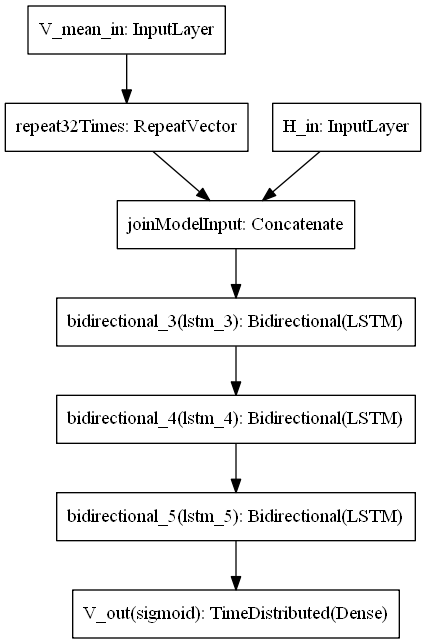

In [31]:
model_inputs = ['H', 'V_mean']
model_outputs = ['V']

model_input_reqs = [m_input for m_input in model_input_reqs_unfiltered if m_input.name in model_inputs]
model_output_reqs = [m_output for m_output in model_output_reqs_unfiltered if m_output.name in model_outputs]

hidden_state = 256
lstm_layers = 2
dense_layers = 1
dense_size = 128
seq_model = models.create_simple_LSTM_RNN(model_input_reqs, model_output_reqs, seq_length=seq_length, dense_layers=dense_layers, dense_size=dense_size)
seq_model.summary()
tf.keras.utils.plot_model(seq_model)

In [32]:
seq_model.load_weights('89-0.31.hdf5')

### Predict

In [48]:
V_pred = seq_model.predict({md.name + '_in': md.data for md in model_datas.values()})

In [50]:
# get predictions for indices where a note exists, or doesn't exist
V_pred_ones = V_pred[np.where(model_datas['H'].data == 1)]
V_pred_zeros = V_pred[np.where(model_datas['H'].data != 1)]

Text(0, 0.5, 'Frequency')

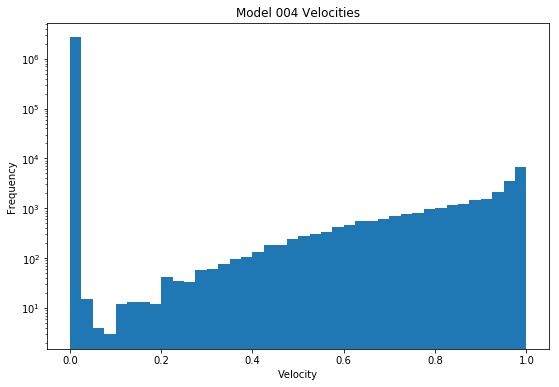

In [47]:
plt.figure(figsize=(9,6))
plt.yscale('log')
plt.hist(V_pred.flatten(), bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
# plt.savefig('004-velocities')

Text(0, 0.5, 'Frequency')

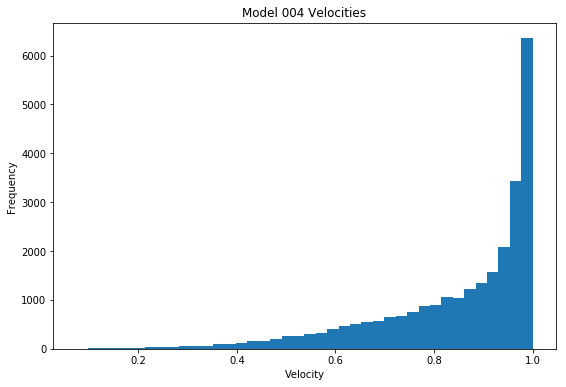

In [52]:
plt.figure(figsize=(9,6))
# plt.yscale('log')
plt.hist(V_pred_ones, bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

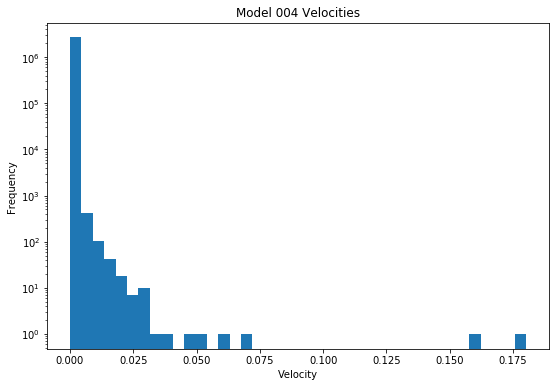

In [53]:
plt.figure(figsize=(9,6))
plt.yscale('log')
plt.hist(V_pred_zeros, bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

In [67]:
np.corrcoef(V_pred_ones, model_datas['V'].data[np.where(model_datas['H'].data == 1)])
# V_pred_ones.shape
# model_datas['V'].data[np.where(model_datas['H'].data == 1)]

array([[1.       , 0.4592872],
       [0.4592872, 1.       ]])

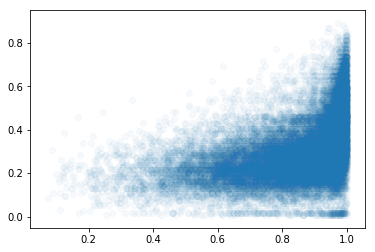

In [75]:
plt.scatter(V_pred_ones, model_datas['V'].data[np.where(model_datas['H'].data == 1)], alpha=0.03)

In [38]:
model_datas['V'].data = V_pred
for i in range(10):
    pm = data.examples2pm(model_datas)
    pm.write(f'test{i}.mid')

example 150 chosen
example 539 chosen
example 225 chosen
example 170 chosen
example 675 chosen
simultaneous pedal events!
simultaneous pedal events!
example 799 chosen
example 384 chosen
example 317 chosen
example 677 chosen
example 774 chosen
simultaneous pedal events!
